In [1]:
import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd

from queue import Queue

from datetime import datetime

from datetime import timedelta

In [2]:
from IPython.display import display, HTML, clear_output
import time

def draw_progress_bar(iteration, total, prefix='', suffix='', length=50):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = '#' * filled_length + '-' * (length - filled_length)
    progress_str = f'{prefix} [{bar}] {percent}% {suffix}'
    return progress_str

In [3]:
image_requests = dd.read_csv('image_requests.csv')

In [4]:
image_requests.shape[0].compute()

5682349

In [5]:
image_requests['request_date_time_object'] = dd.to_datetime(image_requests['request_date_time_object'], format='%Y-%m-%d %H:%M:%S')
image_requests = image_requests[['request_date_time_object', 'requested_bytes']].compute()

In [6]:
image_requests.dtypes

request_date_time_object    datetime64[ns]
requested_bytes                      int64
dtype: object

In [7]:
sample = image_requests.head(100)


In [68]:
image_requests['requested_bytes'].max()

1249490

In [8]:
# if timestamp_counter == 0:
#         timestamp_counter = row['request_date_time_object'][index_row]
#         print(sample['request_date_time_object'][index_row+1] - sample['request_date_time_object'][index_row])

In [9]:
initial = 0
threshold_20secs = timedelta(seconds=19)

data_20secs = 0

time_to = []
data_demand_20secs = []

count = 0

for index_row, row in image_requests.iterrows():
    
    if initial == 0:
        initial = 1
        timestamp_counter = row['request_date_time_object']

    if (row['request_date_time_object'] - timestamp_counter) > threshold_20secs :

        time_to.append(str(row['request_date_time_object']))
        data_demand_20secs.append(data_20secs)

        count += 1
        # draw_progress_bar(count, 21600, prefix='Progress:', suffix='Complete', length=50)

        progress = draw_progress_bar(count, 21600, prefix='Progress:', suffix='Complete', length=50)
        clear_output(wait=True)
        display(HTML(progress))
        
        timestamp_counter = row['request_date_time_object']
        data_20secs = 0
    
    data_20secs += row['requested_bytes']
    

In [11]:
# print(data_demand_10secs)
# print(time_to)

# [632119, 76814, 116312, 670691, 175840]
# ['2019-01-22 04:00:12', '2019-01-22 04:00:23', '2019-01-22 04:00:34', '2019-01-22 04:00:47', '2019-01-22 04:01:00']

demand_data_df = pd.DataFrame({
    'data_demand_20secs': data_demand_20secs,
    'time_to' : time_to
})

demand_data = dd.from_pandas(demand_data_df, npartitions=2)

demand_data.compute()


,data_demand_20secs,time_to
0,708933,2019-01-22 04:00:23
1,674238,2019-01-22 04:00:43
2,355476,2019-01-22 04:01:03
3,635822,2019-01-22 04:01:24
4,136022,2019-01-22 04:01:46
...,...,...
19884,4760300,2019-01-26 20:27:38
19885,2086101,2019-01-26 20:27:58
19886,2025141,2019-01-26 20:28:18
19887,2672399,2019-01-26 20:28:38


In [69]:
demand_data.to_csv('training_data/image_server_demand_with_time.csv', index=False, single_file=True)

['/Users/fyrozdadapeer/Desktop/IIITKota Mtech Course work/3. Coursework/6. Open Ended Project/Project Files/subsets/training_data/image_server_demand_with_time.csv']

In [26]:
demand_data['time_to'] = dd.to_datetime(demand_data['time_to'], format='%Y-%m-%d %H:%M:%S')
demand_data_df['time_to'] = dd.to_datetime(demand_data_df['time_to'], format='%Y-%m-%d %H:%M:%S')


demand_data = demand_data.sort_values(by='time_to')
demand_data_df = demand_data_df.sort_values(by='time_to')

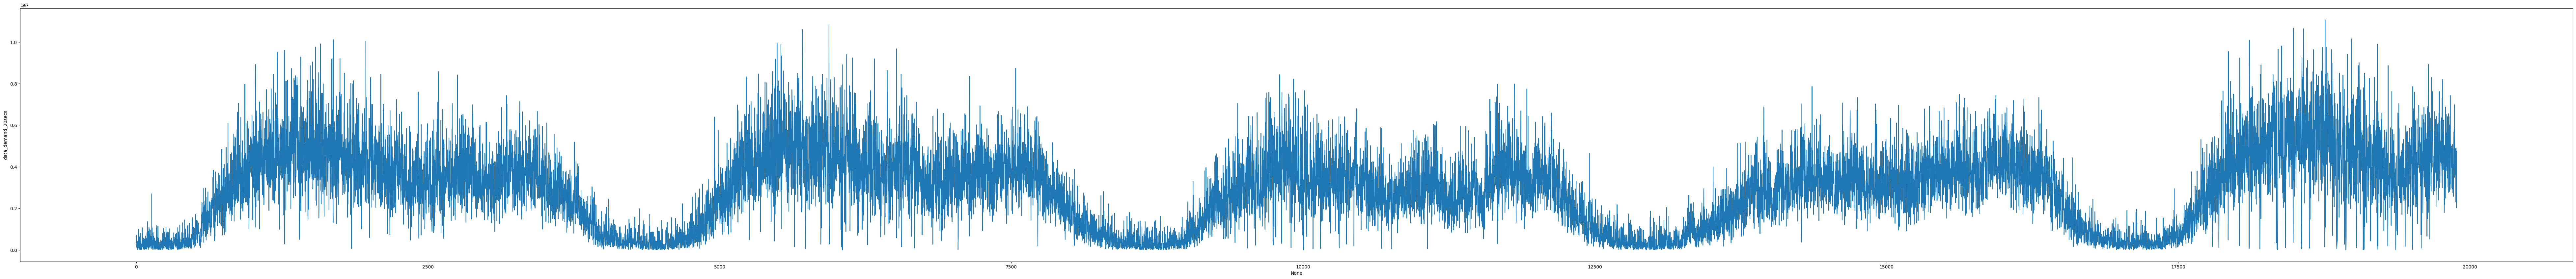

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(100, 10))
sns.lineplot(x=demand_data_df.index, y='data_demand_20secs', data=demand_data_df)
plt.show()

In [15]:
demand_data.head()

,data_demand_20secs,time_to
0,708933,2019-01-22 04:00:23
1,674238,2019-01-22 04:00:43
2,355476,2019-01-22 04:01:03
3,635822,2019-01-22 04:01:24
4,136022,2019-01-22 04:01:46


In [17]:
print(demand_data_df.loc[demand_data_df['data_demand_20secs'].idxmin()])

data_demand_20secs                    189
time_to               2019-01-26 15:10:16
Name: 18937, dtype: object


In [18]:
demand_data.dtypes

data_demand_20secs             int64
time_to               datetime64[ns]
dtype: object

In [29]:
demand_data['Hour'] = demand_data['time_to'].dt.hour * 60 + demand_data['time_to'].dt.minute 
demand_data_df['Hour'] = demand_data_df['time_to'].dt.hour * 60 + demand_data_df['time_to'].dt.minute 

In [31]:
demand_data.head()

,data_demand_20secs,time_to,Hour
0,708933,2019-01-22 04:00:23,240
1,674238,2019-01-22 04:00:43,240
2,355476,2019-01-22 04:01:03,241
3,635822,2019-01-22 04:01:24,241
4,136022,2019-01-22 04:01:46,241


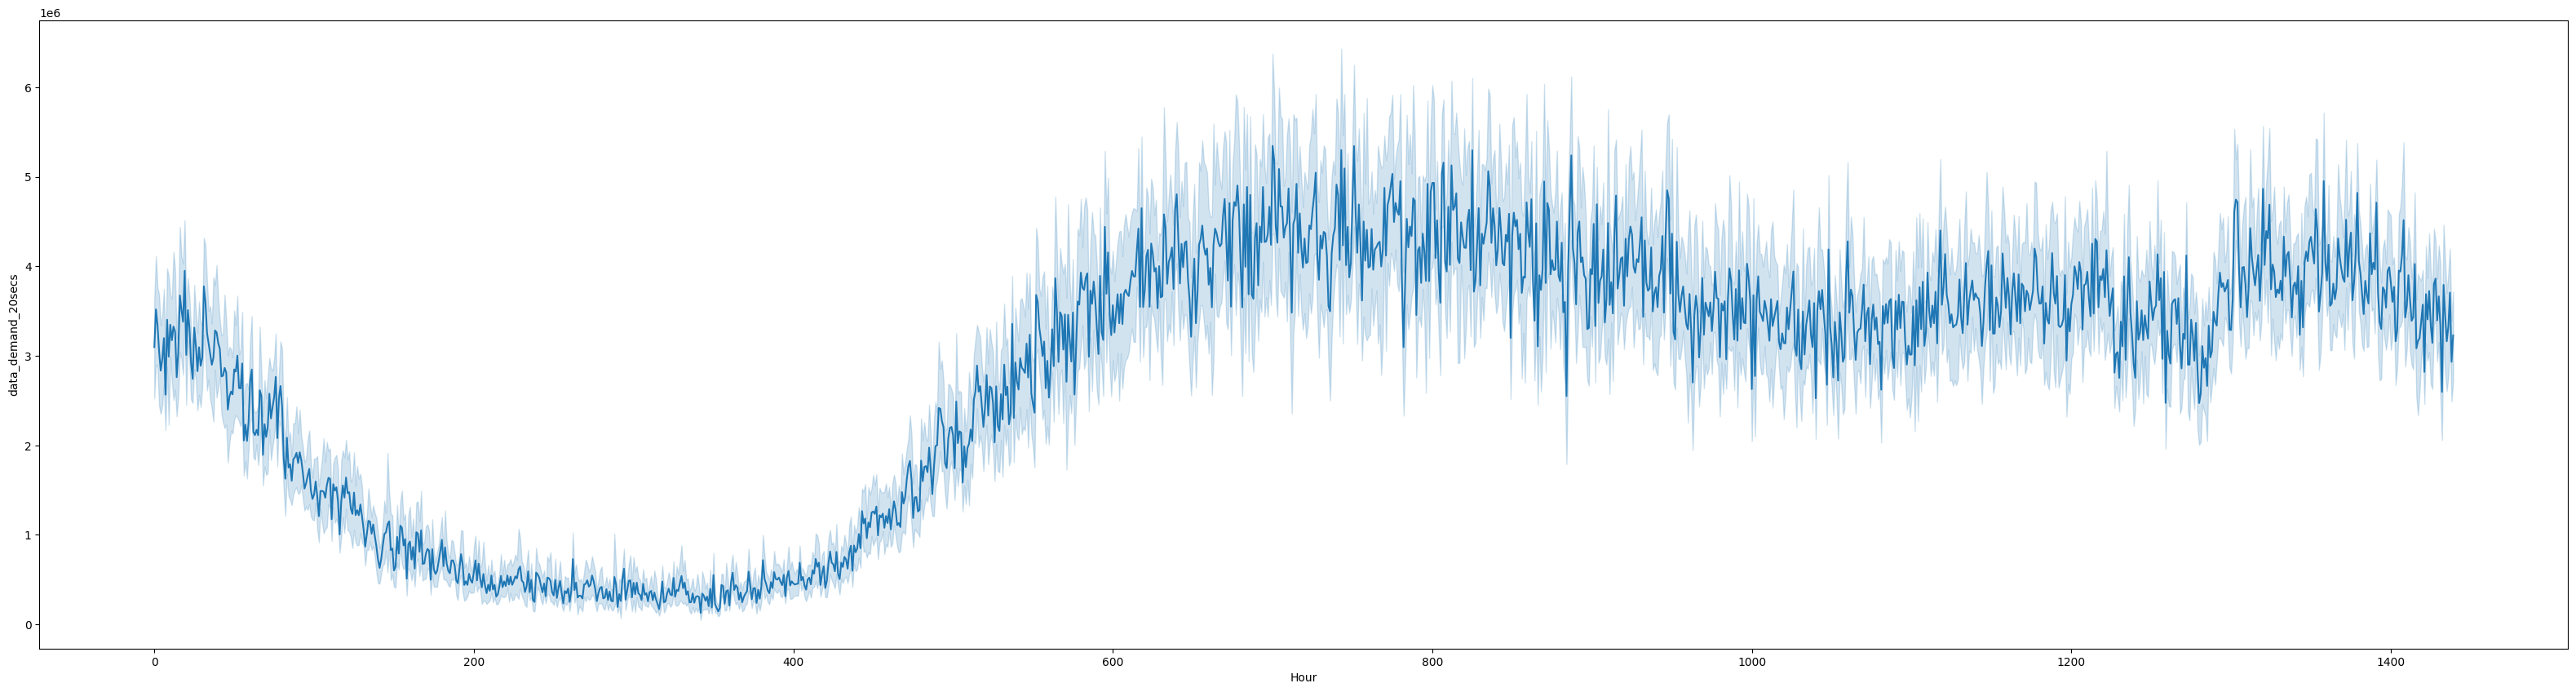

In [30]:
plt.figure(figsize=(40, 10))
sns.lineplot(x='Hour', y='data_demand_20secs', data=demand_data_df)
plt.show()

In [34]:
demand_data = demand_data.sort_values(by='Hour')

In [35]:
demand_data.head()

,data_demand_20secs,time_to,Hour
12016,3701036,2019-01-25 00:00:55,0
16279,3361304,2019-01-26 00:00:59,0
16278,3013475,2019-01-26 00:00:39,0
16277,4227597,2019-01-26 00:00:19,0
12014,4003504,2019-01-25 00:00:15,0


In [36]:
demand_data.shape[0].compute()

19889

In [38]:

count = 0

average_sum = 0
Hour_sum = 0

averages = []
Hour = []

counter = 0

for index_row, row in demand_data.iterrows():
    count +=1
    counter += 1

    progress = draw_progress_bar(counter, 19889, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))
    
    if count > 5:

        averages.append(int(average_sum/5))
        Hour.append(int(Hour_sum/5))
        
        average_sum = 0
        Hour_sum = 0
        
        count = 1
    
    average_sum += row['data_demand_20secs']
    Hour_sum += row['Hour']
    

In [41]:
demand_data_average = pd.DataFrame({
    'data_demand_20secs_average': averages,
    'Minute' : Hour
})

In [44]:
demand_data_average.shape[0]

3977

In [45]:
demand_data_average = demand_data_average.sort_values(by='Minute')

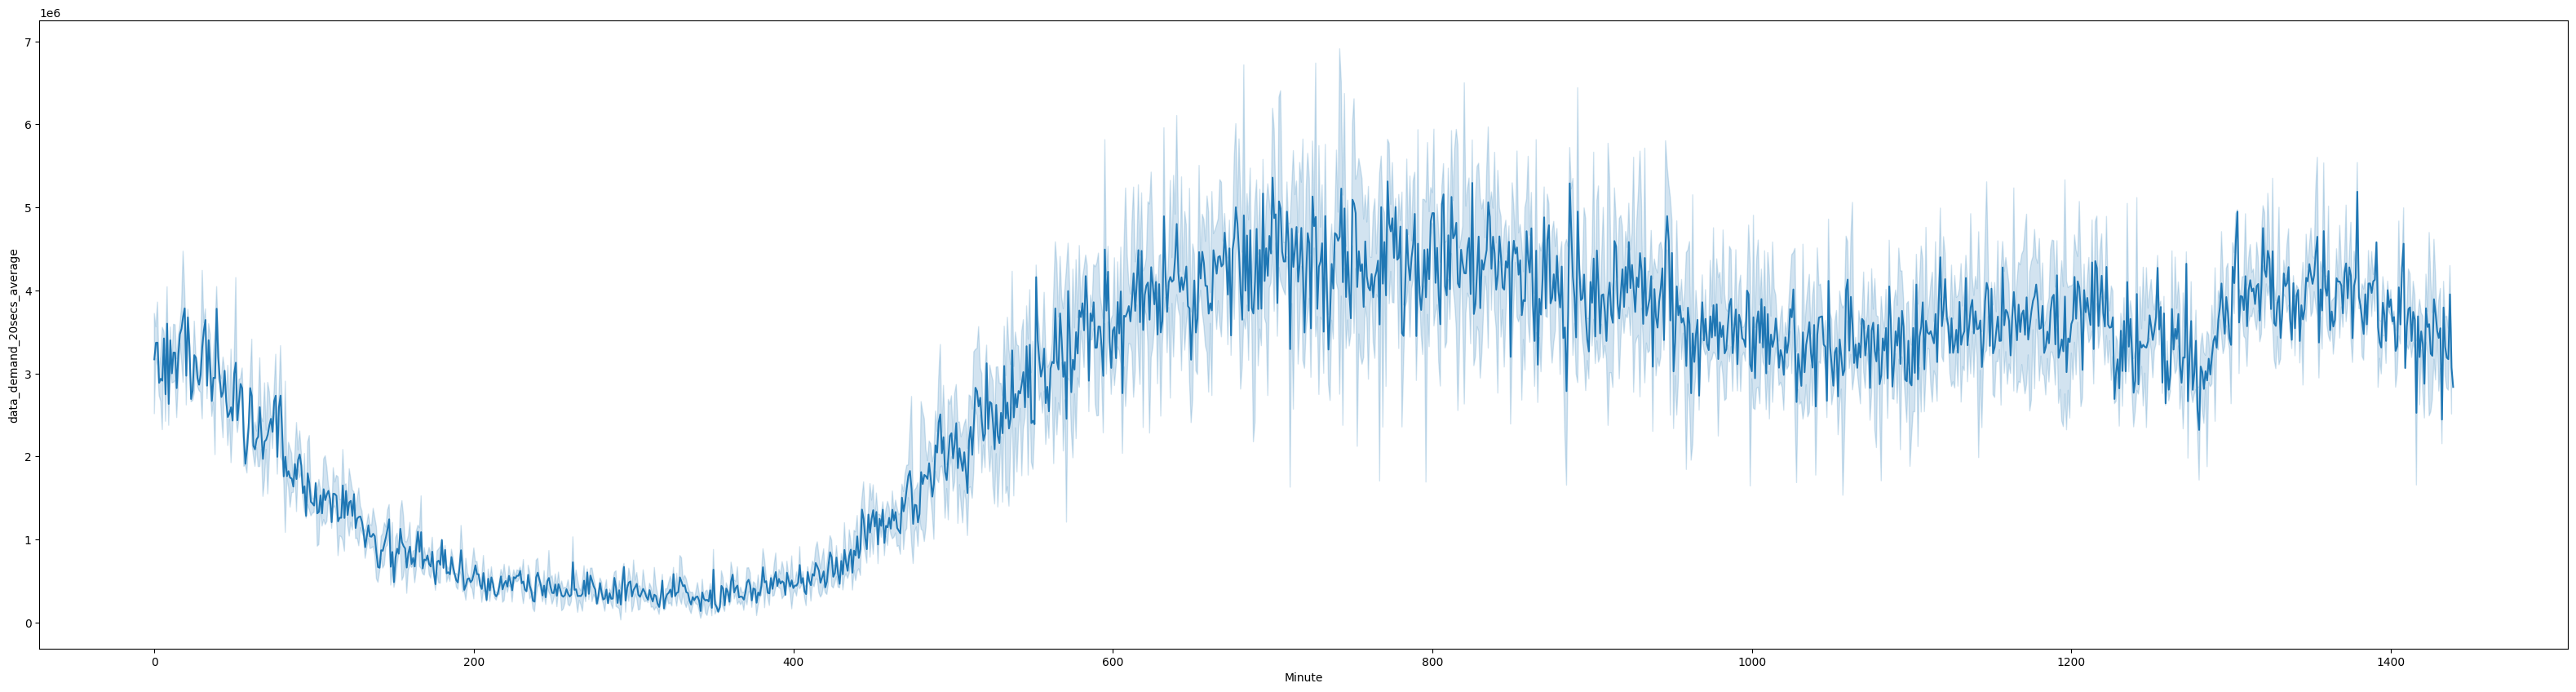

In [46]:
plt.figure(figsize=(40, 10))
sns.lineplot(x='Minute', y='data_demand_20secs_average', data=demand_data_average)
plt.show()

## Last 2 Mins Average

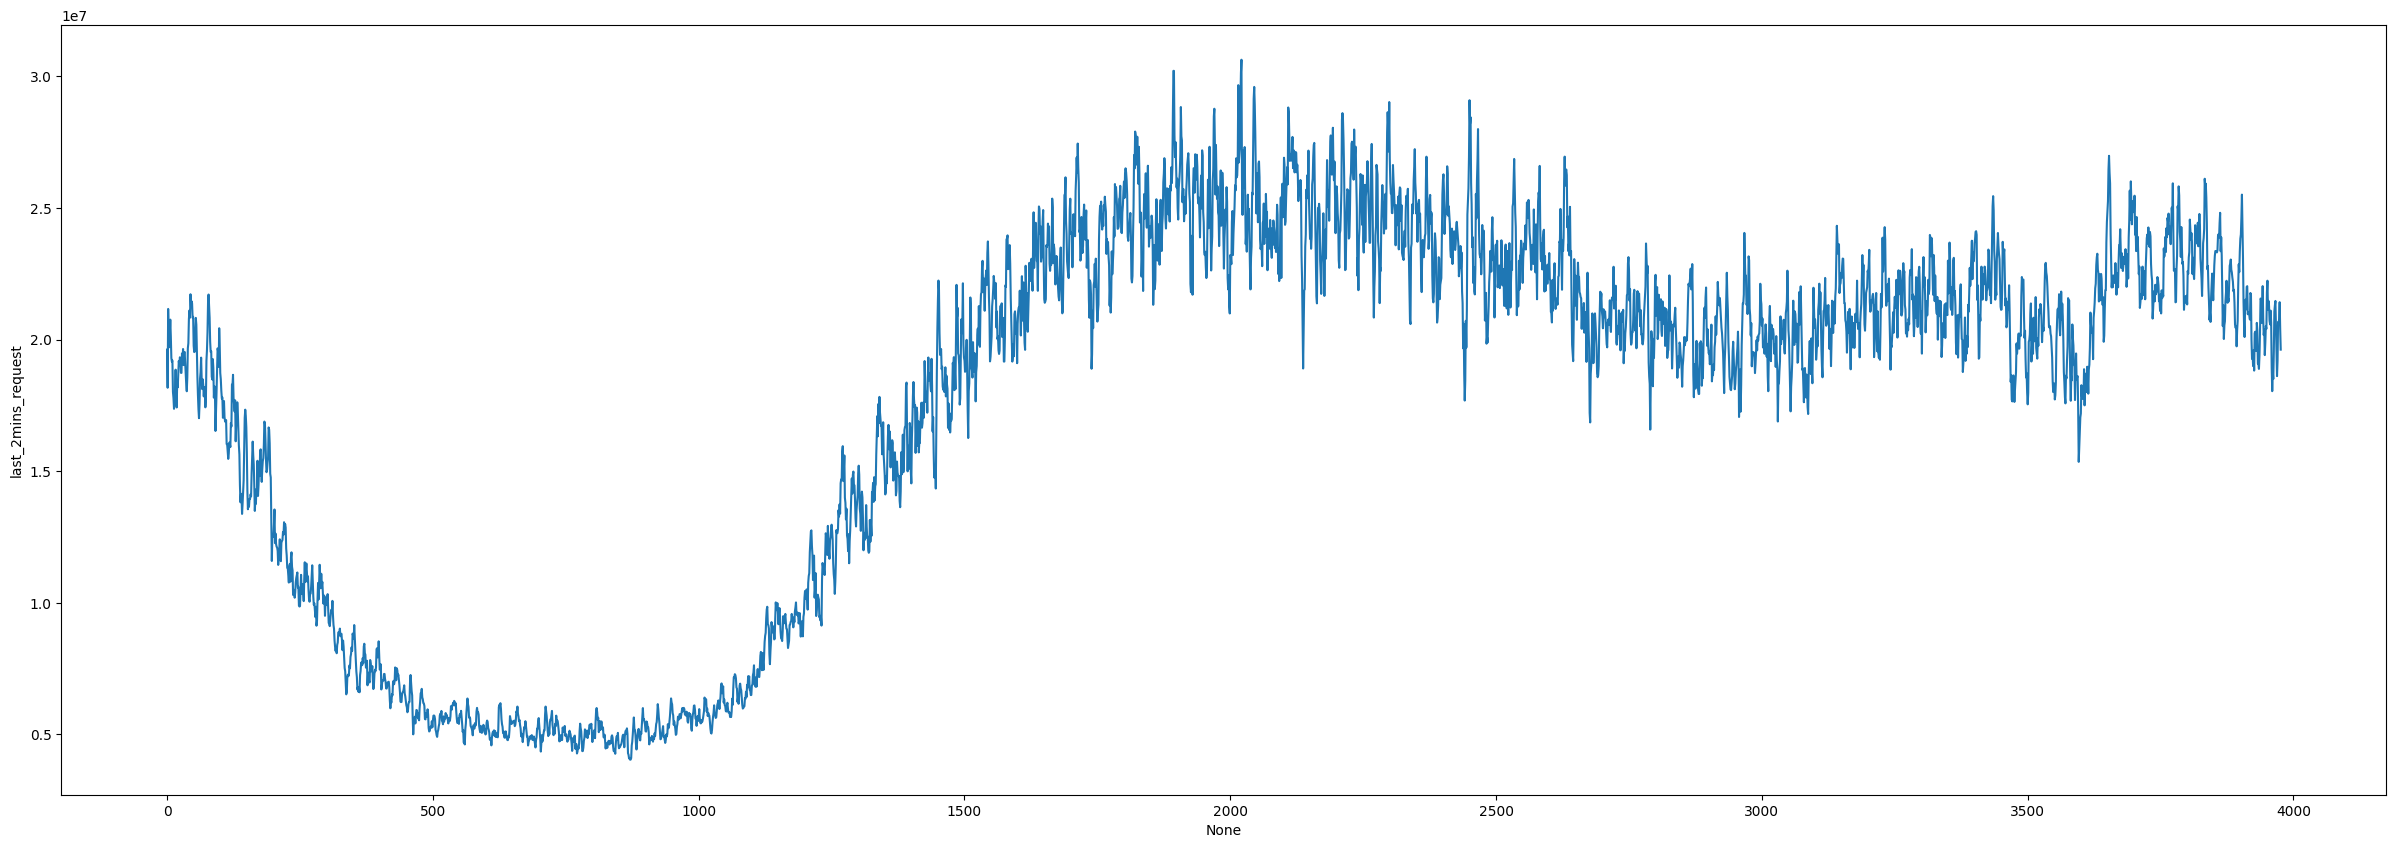

In [58]:
index = 0

sum_last_2mins = 0

last_2mins_request_array = []

for index_row, row in demand_data_average.iterrows():

    sum_last_2mins += row['data_demand_20secs_average']
    
    if index < 6:
        last_2mins_request_array.append(0)
        index += 1
    else :
        sum_last_2mins = sum_last_2mins - demand_data_average['data_demand_20secs_average'][index-5]
        last_2mins_request_array.append(sum_last_2mins)
        index += 1

    progress = draw_progress_bar(index, 3977, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))

last_2mins_request_df = pd.DataFrame({
    'last_2mins_request': last_2mins_request_array
})

sum_last_2mins_aux = 0
for i in range(0, 6):
    sum_last_2mins_aux += demand_data_average['data_demand_20secs_average'][3976-(5-i)]
    
for i in range(0, 6):
    last_2mins_request_df['last_2mins_request'][i] = sum_last_2mins_aux - demand_data_average['data_demand_20secs_average'][3976-(5-i)] + demand_data_average['data_demand_20secs_average'][i]

plt.figure(figsize=(30, 10))
sns.lineplot(x=last_2mins_request_df.index, y='last_2mins_request', data=last_2mins_request_df)
plt.show()

## Last 10 mins average

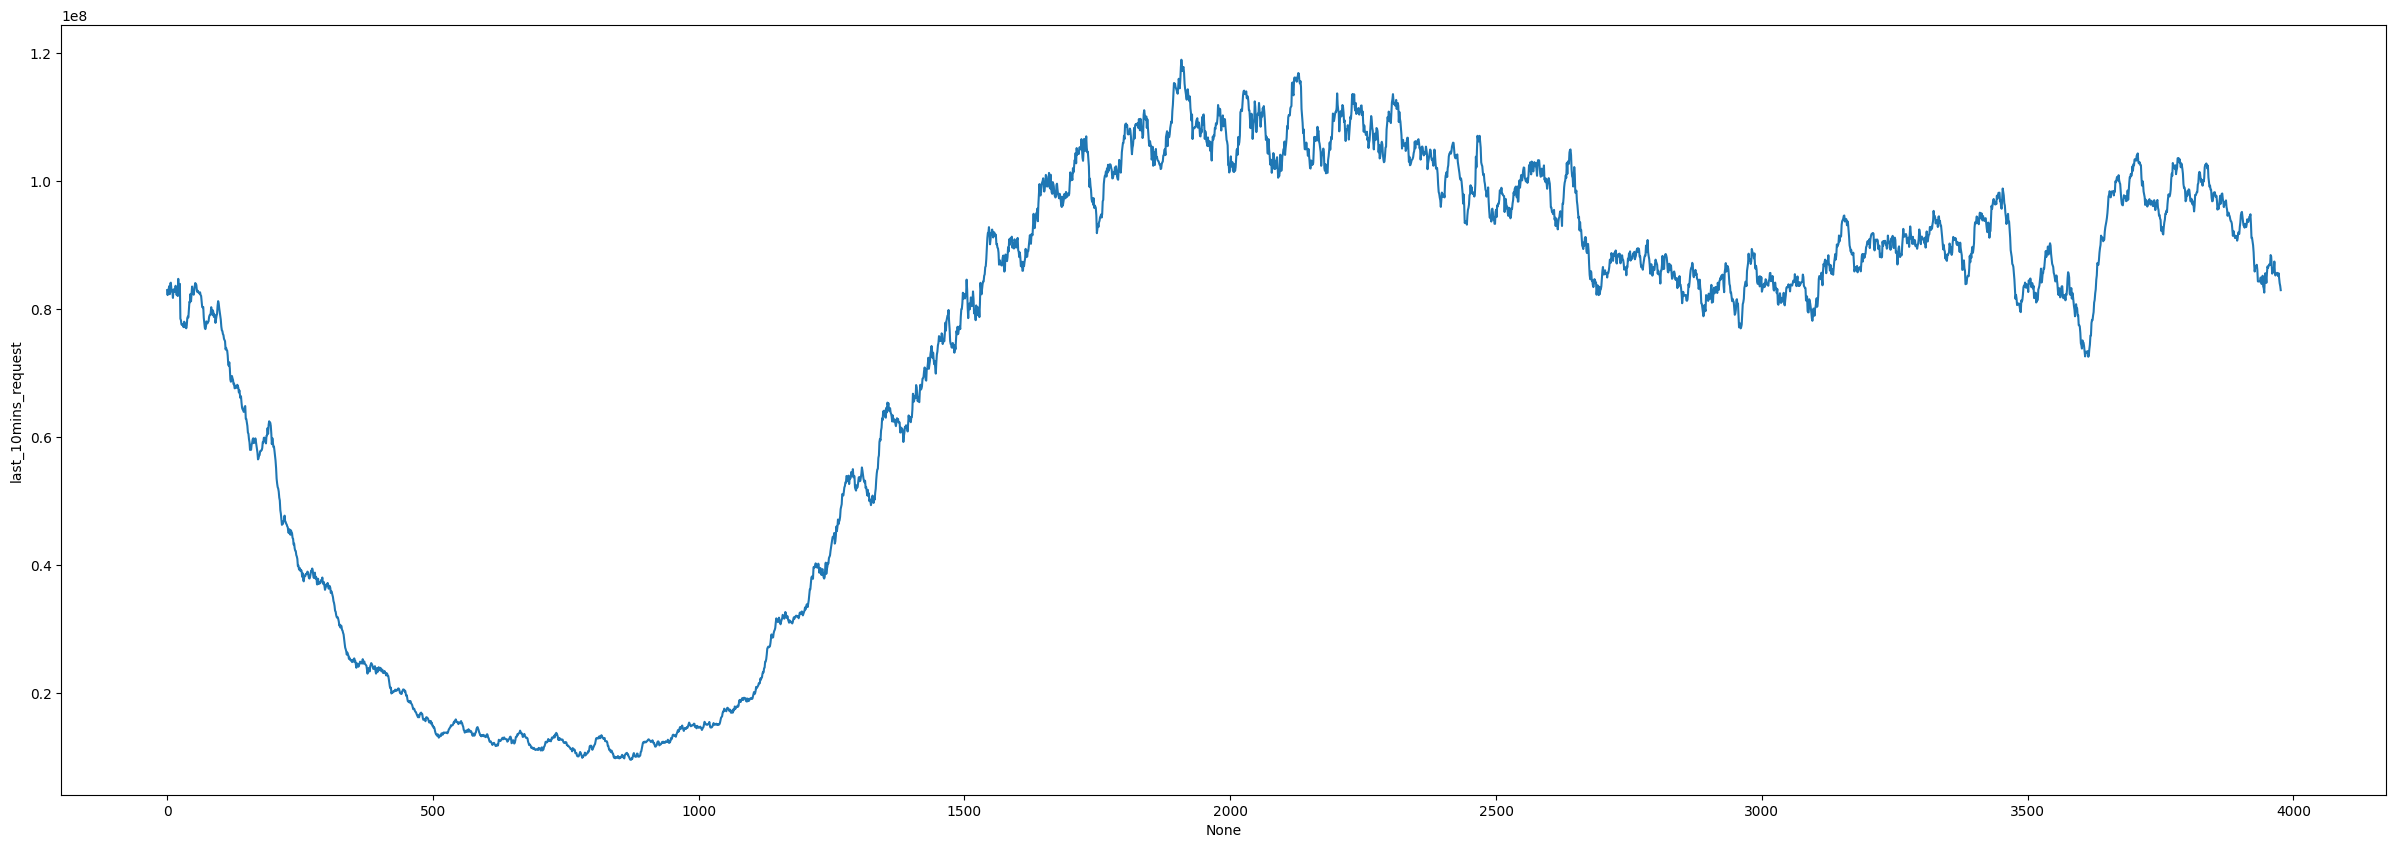

In [59]:
index = 0

sum_last_10mins = 0

last_10mins_request_array = []

for index_row, row in demand_data_average.iterrows():

    sum_last_10mins += row['data_demand_20secs_average']
    
    if index < 25:
        last_10mins_request_array.append(0)
        index += 1
    else :
        sum_last_10mins = sum_last_10mins - demand_data_average['data_demand_20secs_average'][index-24]
        last_10mins_request_array.append(sum_last_10mins)
        index += 1

    progress = draw_progress_bar(index, 3977, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))

last_10mins_request_df = pd.DataFrame({
    'last_10mins_request': last_10mins_request_array
})

sum_last_10mins_aux = 0
for i in range(0, 25):
    sum_last_10mins_aux += demand_data_average['data_demand_20secs_average'][3976-(24-i)]
    
for i in range(0, 25):
    last_10mins_request_df['last_10mins_request'][i] = sum_last_10mins_aux - demand_data_average['data_demand_20secs_average'][3976-(24-i)] + demand_data_average['data_demand_20secs_average'][i]

plt.figure(figsize=(30, 10))
sns.lineplot(x=last_10mins_request_df.index, y='last_10mins_request', data=last_10mins_request_df)
plt.show()

## Last 30 mins average

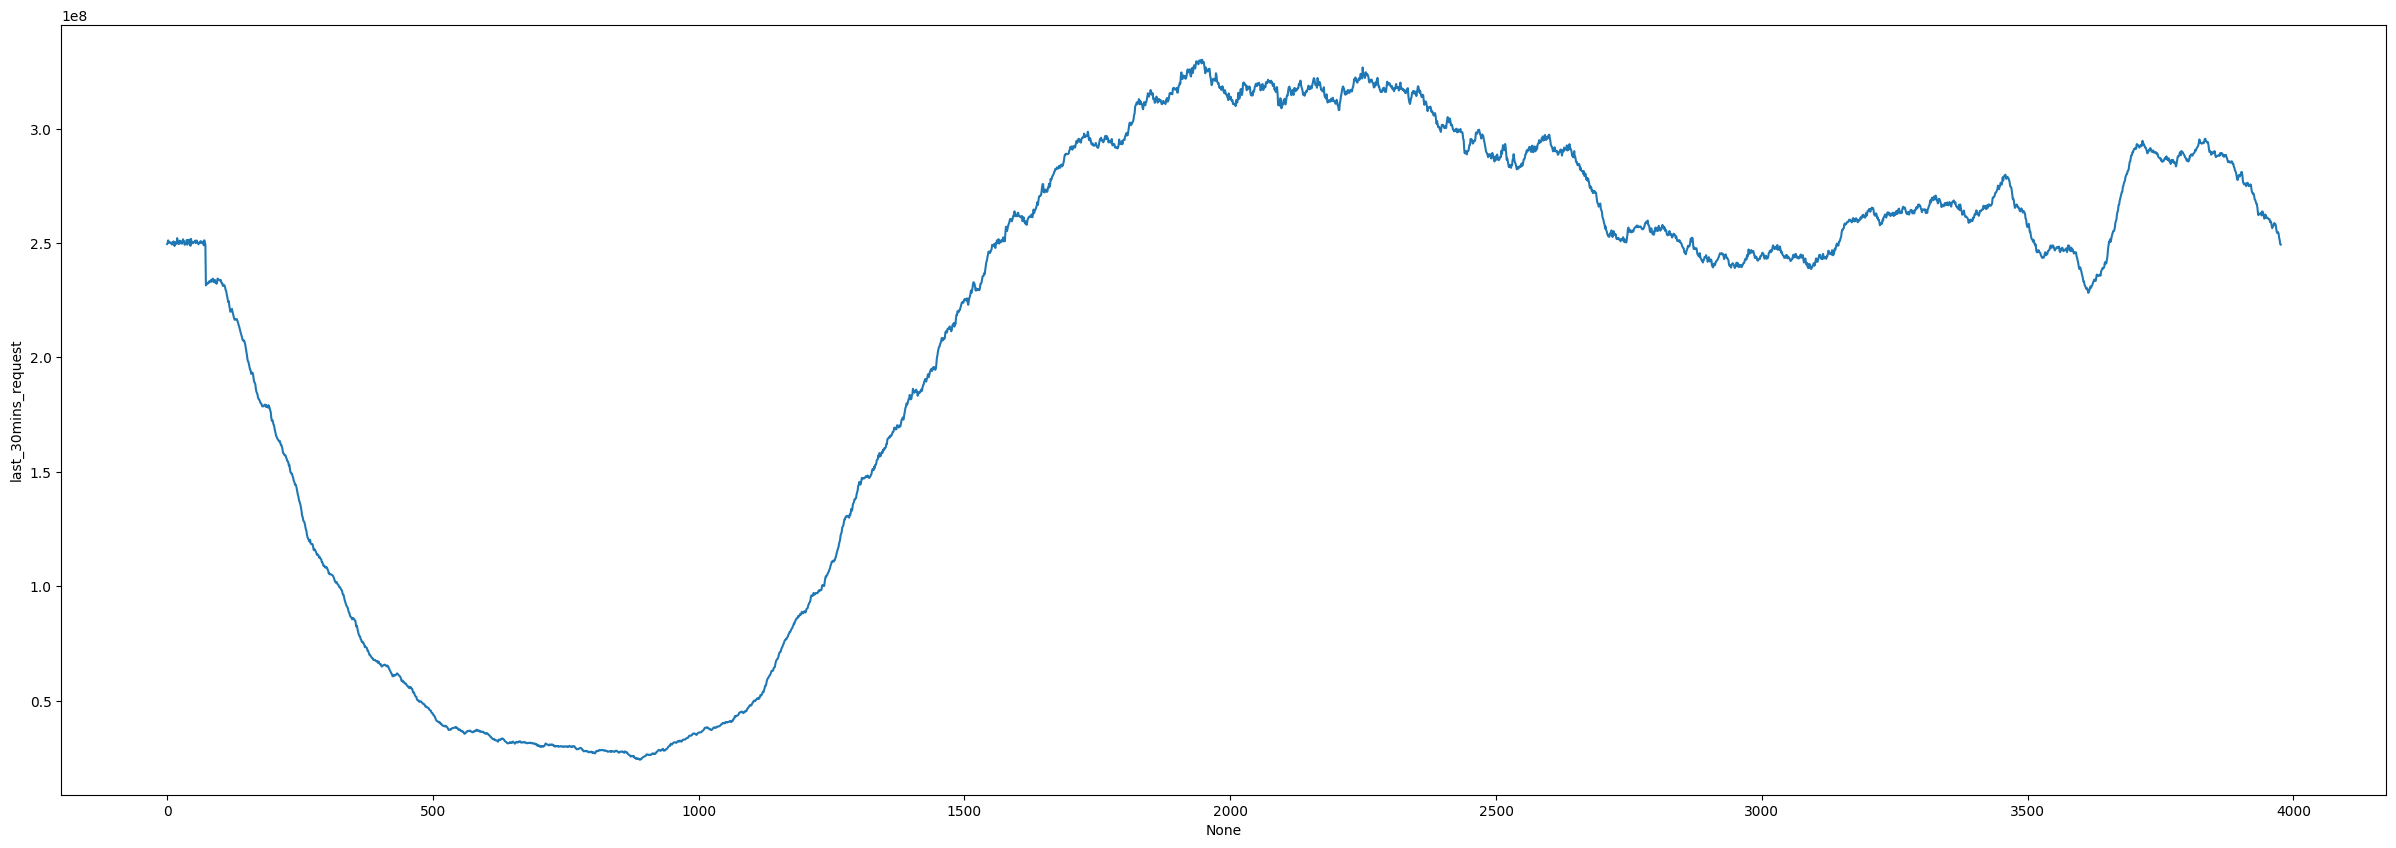

In [60]:
index = 0

sum_last_30mins = 0

last_30mins_request_array = []

for index_row, row in demand_data_average.iterrows():

    sum_last_30mins += row['data_demand_20secs_average']
    
    if index < 73:
        last_30mins_request_array.append(0)
        index += 1
    else :
        sum_last_30mins = sum_last_30mins - demand_data_average['data_demand_20secs_average'][index-72]
        last_30mins_request_array.append(sum_last_30mins)
        index += 1

    progress = draw_progress_bar(index, 3977, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))

last_30mins_request_df = pd.DataFrame({
    'last_30mins_request': last_30mins_request_array
})

sum_last_30mins_aux = 0
for i in range(0, 73):
    sum_last_30mins_aux += demand_data_average['data_demand_20secs_average'][3976-(73-i)]
    
for i in range(0, 73):
    last_30mins_request_df['last_30mins_request'][i] = sum_last_30mins_aux - demand_data_average['data_demand_20secs_average'][3976-(73-i)] + demand_data_average['data_demand_20secs_average'][i]

plt.figure(figsize=(30, 10))
sns.lineplot(x=last_30mins_request_df.index, y='last_30mins_request', data=last_30mins_request_df)
plt.show()

## Last 60 mins average

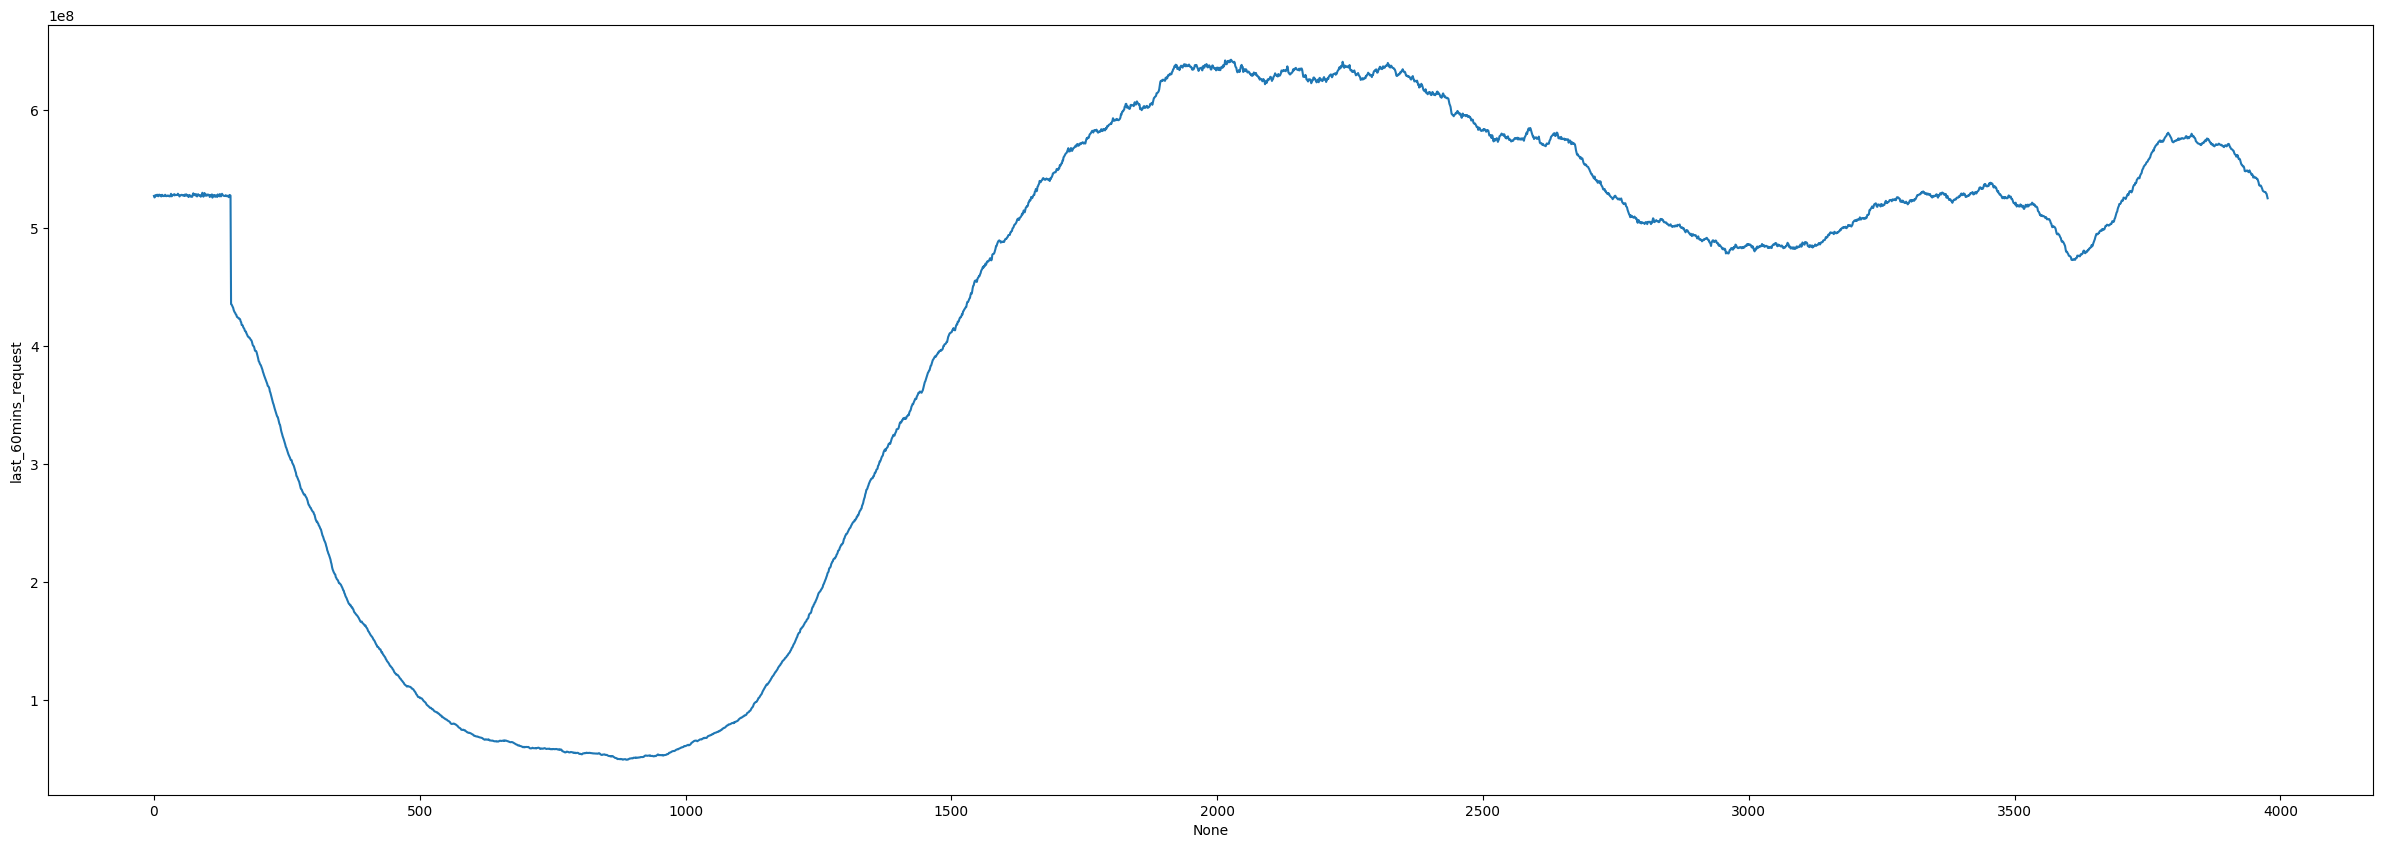

In [62]:
index = 0

sum_last_60mins = 0

last_60mins_request_array = []

for index_row, row in demand_data_average.iterrows():

    sum_last_60mins += row['data_demand_20secs_average']
    
    if index < 145:
        last_60mins_request_array.append(0)
        index += 1
    else :
        sum_last_60mins = sum_last_60mins - demand_data_average['data_demand_20secs_average'][index-144]
        last_60mins_request_array.append(sum_last_60mins)
        index += 1

    progress = draw_progress_bar(index, 3977, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))

last_60mins_request_df = pd.DataFrame({
    'last_60mins_request': last_60mins_request_array
})

sum_last_60mins_aux = 0
for i in range(0, 145):
    sum_last_60mins_aux += demand_data_average['data_demand_20secs_average'][3976-(145-i)]
    
for i in range(0, 145):
    last_60mins_request_df['last_60mins_request'][i] = sum_last_60mins_aux - demand_data_average['data_demand_20secs_average'][3976-(145-i)] + demand_data_average['data_demand_20secs_average'][i]

plt.figure(figsize=(30, 10))
sns.lineplot(x=last_60mins_request_df.index, y='last_60mins_request', data=last_60mins_request_df)
plt.show()

## Last 180 mins average

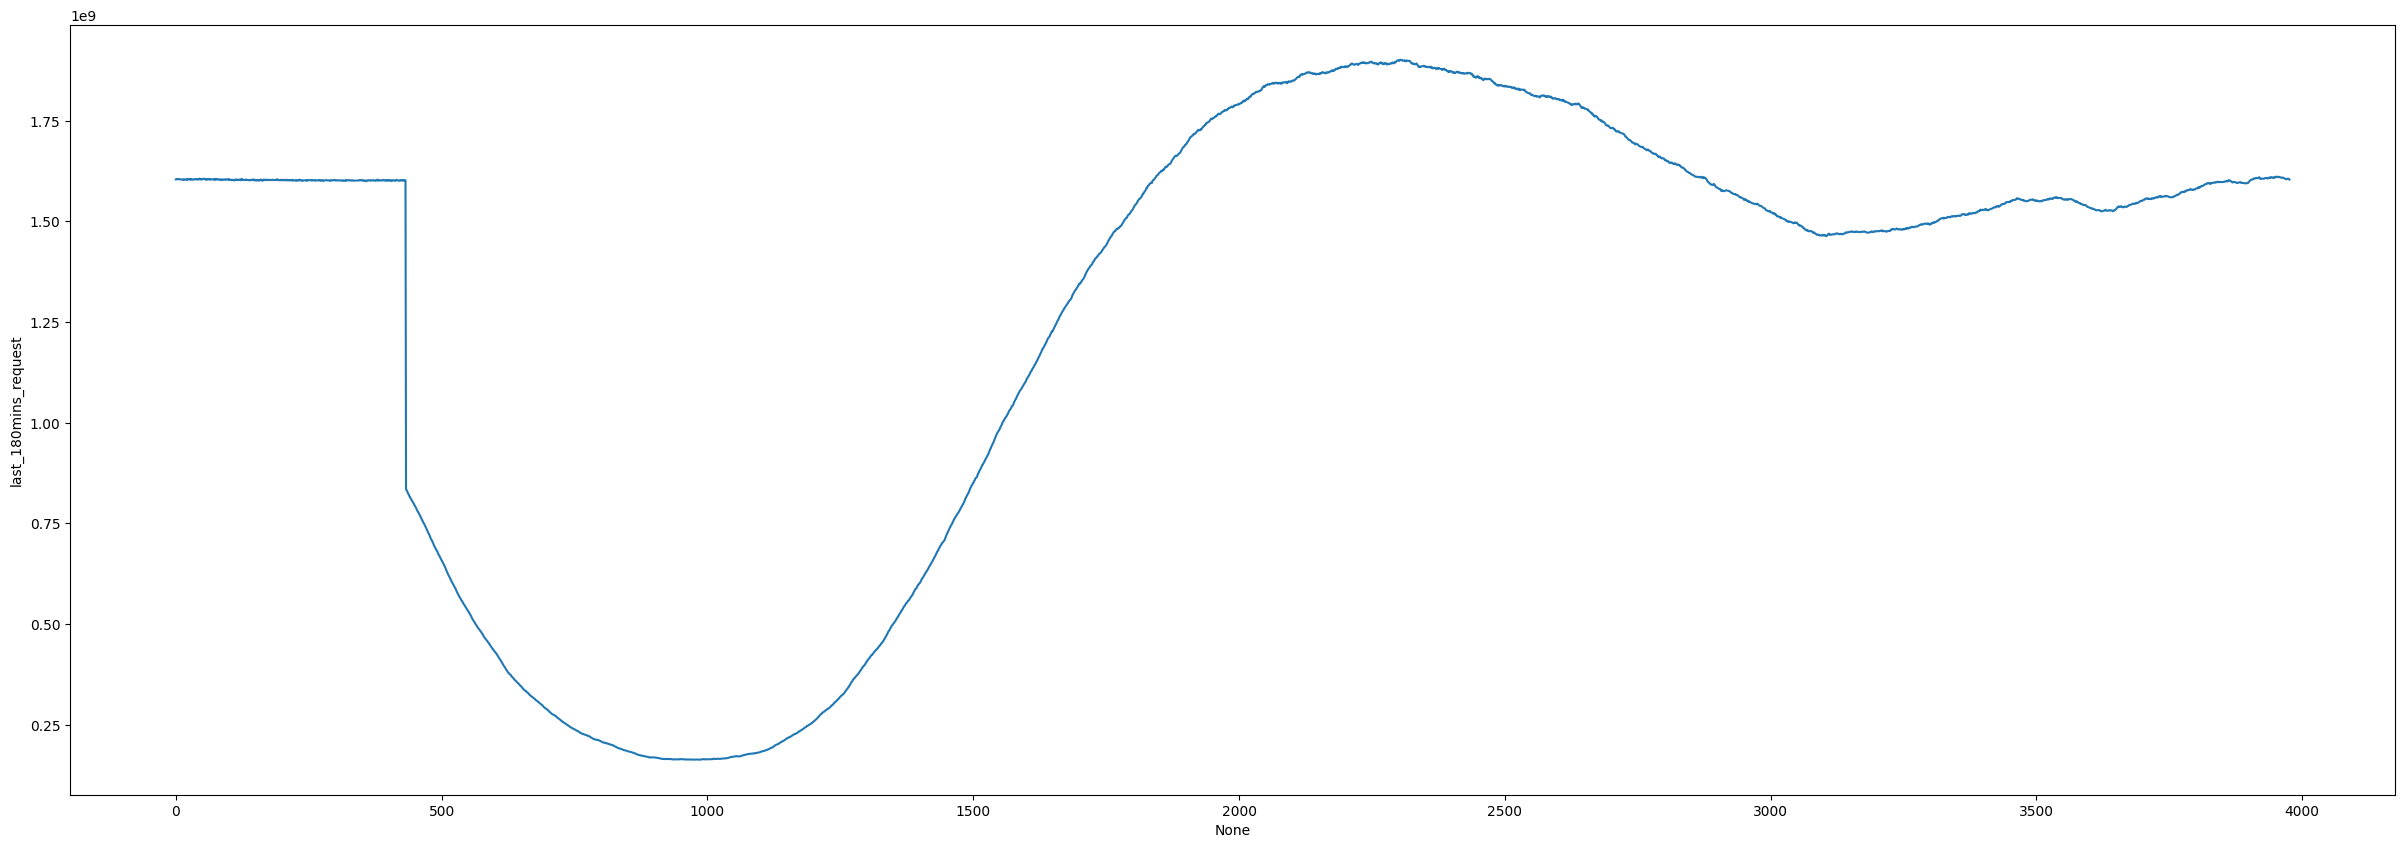

In [63]:
index = 0

sum_last_180mins = 0

last_180mins_request_array = []

for index_row, row in demand_data_average.iterrows():

    sum_last_180mins += row['data_demand_20secs_average']
    
    if index < 433:
        last_180mins_request_array.append(0)
        index += 1
    else :
        sum_last_180mins = sum_last_180mins - demand_data_average['data_demand_20secs_average'][index-433]
        last_180mins_request_array.append(sum_last_180mins)
        index += 1

    progress = draw_progress_bar(index, 3977, prefix='Progress:', suffix='Complete', length=50)
    clear_output(wait=True)
    display(HTML(progress))

last_180mins_request_df = pd.DataFrame({
    'last_180mins_request': last_180mins_request_array
})

sum_last_180mins_aux = 0
for i in range(0, 433):
    sum_last_180mins_aux += demand_data_average['data_demand_20secs_average'][3976-(433-i)]
    
for i in range(0, 433):
    last_180mins_request_df['last_180mins_request'][i] = sum_last_180mins_aux - demand_data_average['data_demand_20secs_average'][3976-(433-i)] + demand_data_average['data_demand_20secs_average'][i]

plt.figure(figsize=(30, 10))
sns.lineplot(x=last_180mins_request_df.index, y='last_180mins_request', data=last_180mins_request_df)
plt.show()

In [64]:
print(demand_data_average.shape[0])
print(last_2mins_request_df.shape[0])
print(last_10mins_request_df.shape[0])
print(last_30mins_request_df.shape[0])
print(last_60mins_request_df.shape[0])
print(last_180mins_request_df.shape[0])

3977
3977
3977
3977
3977
3977


In [65]:
# Add all features calculated inside a single dataframe

final_training_set = dd.from_pandas(pd.DataFrame({'demand_data_average': demand_data_average['data_demand_20secs_average'], 
                                                  'last_2mins_request': last_2mins_request_df['last_2mins_request'],
                                                  'last_10mins_request': last_10mins_request_df['last_10mins_request'],
                                                  'last_30mins_request': last_30mins_request_df['last_30mins_request'],
                                                  'last_60mins_request': last_60mins_request_df['last_60mins_request'],
                                                  'last_180mins_request': last_180mins_request_df['last_180mins_request'],
                                                 }
                                                ), 
                                                npartitions=2)


final_training_set.compute()

,demand_data_average,last_2mins_request,last_10mins_request,last_30mins_request,last_60mins_request,last_180mins_request
0,3271238,19616155,82948536,249568792,527270906,1604092836
1,2515438,18167029,82177246,249975773,525979138,1604113416
2,3722618,21162825,83021375,251181297,526483901,1605367713
3,3561632,20240692,83128174,250326401,527914610,1604431621
4,3178138,19705954,83570175,250360416,527452969,1604413015
...,...,...,...,...,...,...
3972,4300009,20579718,85583367,254051020,530525897,1605804732
3973,2511393,20794751,84782794,252328770,529539039,1606057086
3974,3272540,21420156,84024915,251284590,529061549,1605678853
3975,3423784,20385647,83614407,249568792,527270906,1604261619


In [ ]:
# Z-score normalization

# Applying z-score normalization before making more features
# That's why retaining mean and standard deviation

# In production, for 20 secs data - z score will be applied. 
# for 2 mins and 10 mins, 40mins, 2hours - we will measure the max min and all those values, and note it down to implement it in production. 
# We will use sliders to show the working of the model

In [66]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

columns_to_normalize = ['last_2mins_request', 'last_10mins_request', 'last_30mins_request', 'last_60mins_request', 'last_180mins_request']

final_training_set[columns_to_normalize] = dd.from_pandas(pd.DataFrame(scaler.fit_transform(final_training_set.compute()[columns_to_normalize]), columns=columns_to_normalize), npartitions=2)
final_training_set.compute()

,demand_data_average,last_2mins_request,last_10mins_request,last_30mins_request,last_60mins_request,last_180mins_request
0,3271238,0.277887,0.317401,0.389392,0.540269,0.567018
1,2515438,0.074041,0.294484,0.393439,0.533832,0.567053
2,3722618,0.495453,0.319565,0.405428,0.536347,0.569203
3,3561632,0.365739,0.322738,0.396926,0.543477,0.567598
4,3178138,0.290518,0.335871,0.397265,0.541177,0.567566
...,...,...,...,...,...,...
3972,4300009,0.413429,0.395686,0.433967,0.556490,0.569953
3973,2511393,0.443677,0.371900,0.416840,0.551572,0.570385
3974,3272540,0.531652,0.349382,0.406455,0.549193,0.569737
3975,3423784,0.386129,0.337185,0.389392,0.540269,0.567307


In [67]:
final_training_set.to_csv('training_data/image_server_demand.csv', index=False, single_file=True)

['/Users/fyrozdadapeer/Desktop/IIITKota Mtech Course work/3. Coursework/6. Open Ended Project/Project Files/subsets/training_data/image_server_demand.csv']

In [ ]:
# After this model training

In [ ]:
# from ipywidgets import interact, widgets

# # Sigmoid function
# def sigmoid(x, a, b):
#     return 1 / (1 + np.exp(-(a * (x - b))))

# # Function to update plot with interactive sliders
# def update_plot(a, b):
#     x_values = np.linspace(-10, 10, 100)
#     y_values = sigmoid(x_values, a, b)

#     plt.plot(x_values, y_values, label=f'Sigmoid curve (a={a}, b={b})')
#     plt.title('Interactive Sigmoid Curve')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.legend()
#     plt.show()

# # Create sliders for parameters
# a_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='a:')
# b_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='b:')

# # Create interactive plot
# interact(update_plot, a=a_slider, b=b_slider)